# <center>Methods of Applied Mathematics Team Project

## 네이버 검색어 키워드를 통한 테마주 네트워크 구성

In [1]:
from itertools import combinations
import datetime
import numpy as np
import pandas as pd
import networkx as nx
from scipy import spatial
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='grade3')
%matplotlib inline

### 후보별 종목구성

In [2]:
# 안철수
# Ahn_1 = ['042500', '048830','053800','049480','218150','025560','004770']
# 218150 : 미래생명자원 -> 중간에 거래정지 기간이 있어서 제외
Ahn_1 = ['042500', '048830','053800','049480','025560','004770']

In [3]:
# 문재인
Moon = ['115500','102120','155660','065650','042110','096630','069730','119850','002140','035890','039560']

In [4]:
# 안희정
Ahn_2 = ['224060','003310','013720','088290','054410','046310','036120']

### MST Tutorial

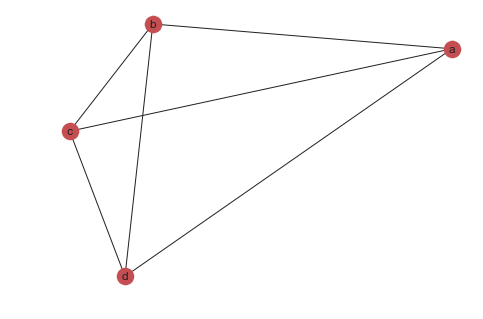

In [5]:
G = nx.Graph()
G.add_edge('a', 'b',weight=5)
G.add_edge('a','c',weight=3)
G.add_edge('a','d',weight=1)
G.add_edge('b','c',weight=15)
G.add_edge('b','d',weight=3)
G.add_edge('c','d',weight=8)
nx.draw(G,with_labels=True)

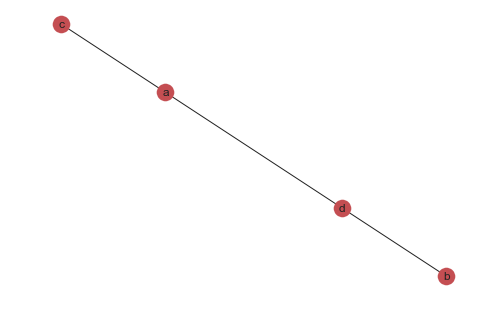

In [6]:
G_mst = nx.algorithms.tree.mst.minimum_spanning_tree(G)
nx.draw(G_mst,with_labels=True)

In [7]:
edges = list(G_mst.edges)
edges[0]

('a', 'd')

In [8]:
cost = 0
for i in edges:
    cost += G_mst.edges[i]['weight']
cost

7

In [9]:
G.nodes['a']['data'] = [1,2,3]
G.nodes['a']['data']

[1, 2, 3]

### 후보별 테마주 네트워크 구성

In [77]:
class construct_network:
    
    def __init__(self,period,stock_list,stock_data):
        self.stock_data = stock_data
        self.stock_data = self.stock_data.set_index(['date','code']).unstack()
        self.stock_data = self.stock_data['close']
        self.period = self.stock_data[period[0]:period[1]].index
        self.stock_list = stock_list
        self.portfolio = self.get_portfolio(self.period)
        self.cost = pd.Series(self.period).apply(lambda x : self.get_cost(x)) / (len(self.stock_list) - 1)
        self.cost.index = self.period
        self.plot_things()        
    
    def get_portfolio(self,period):
        stock_data = self.stock_data[period[0]:period[-1]]
        return stock_data.apply(lambda x : x/x.iloc[0], axis=0).sum(axis=1)/len(self.stock_data.columns)
        
    # min_max scale 함수
    def get_minmax_scale(self, series):
        return (series-series.min())/(series.max()-series.min())
    
    def get_cost(self,date):
        period=100
        start_date = date + datetime.timedelta(days=-period)
        G = nx.Graph()
        G.add_nodes_from(self.stock_list)
        for i in list(G.nodes):
            G.nodes[i]['data'] = self.get_minmax_scale(self.stock_data[i][start_date:date]).fillna(0)

        iter_list = combinations(list(G.nodes),2)
        for i in iter_list:
            d1 = G.nodes[i[0]]['data']
            d2 = G.nodes[i[1]]['data']
            sim = 1 - spatial.distance.cosine(d1, d2)
            G.add_edge(i[0],i[1],weight=sim)


        G_mst = nx.algorithms.tree.mst.minimum_spanning_tree(G)
        # nx.draw(G_mst,with_labels=True)

        edges = list(G_mst.edges)
        cost = 0
        for i in edges:
            cost += G_mst.edges[i]['weight'] #Calculate the cost for constructing MST
        # print(start_date, date, cost)

        return cost
    
    def plot_things(self):
        self.plt_result()
        before_period = self.stock_data[self.period[0]:'2016-12-09'].index
        during_period = self.stock_data['2016-12-09':'2017-05-09'].index
        after_period = self.stock_data['2017-05-09':self.period[-1]].index
        self.plt_period(before_period)
        self.plt_period(during_period)
        self.plt_period(after_period)
    
    def plt_result(self):
        plt.figure(figsize=(12,7))
        plt.plot(self.cost, label='MST Construction Cost')
        plt.plot(self.portfolio - 1, label='Portfolio Return(Same Cash Weight)')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(12,7))
        plt.plot(self.cost.rolling(window=2).apply(lambda x : x[1] - x[0]), label='MST Cost Daily Difference')
        plt.legend()
        plt.show()
        return 0
    
    def plt_period(self,period):
        plt.figure(figsize=(12,7))
        port = self.get_portfolio(period)
        plt.plot(self.cost[period[0]:period[-1]], label='MST Construction Cost')
        plt.plot(port - 1, label='Portfolio Return(Same Cash Weight)')
        plt.legend()
        plt.show()
        print("Mean : ", self.cost[period[0]:period[-1]].mean())
        print("Std : ", self.cost[period[0]:period[-1]].std())
        print("Port_folio_Std : ", port.std())

### 분석기간 설정 (대선 기간 전 ~ 대선 기간 이후)

In [78]:
start_date = datetime.datetime.strptime('2016-06-09', '%Y-%m-%d')
start_date

datetime.datetime(2016, 6, 9, 0, 0)

In [79]:
end_date = datetime.datetime.strptime('2017-11-09', '%Y-%m-%d')
end_date

datetime.datetime(2017, 11, 9, 0, 0)

In [80]:
time_period = (start_date, end_date)

In [81]:
AhnCheolSoo_stock = pd.read_csv('AhnCheolSoo.csv',index_col=0)
AhnCheolSoo_stock['date'] = pd.to_datetime(AhnCheolSoo_stock['date'])
AhnCheolSoo_stock['code'] = AhnCheolSoo_stock['code'].apply(lambda x : x[1:])
AhnCheolSoo_stock.head()

,date,code,close
0,2016-01-04,053800,86200.000
1,2016-01-04,042500,5200.000
2,2016-01-04,049480,3055.000
3,2016-01-04,025560,447.073
4,2016-01-04,048830,4140.970


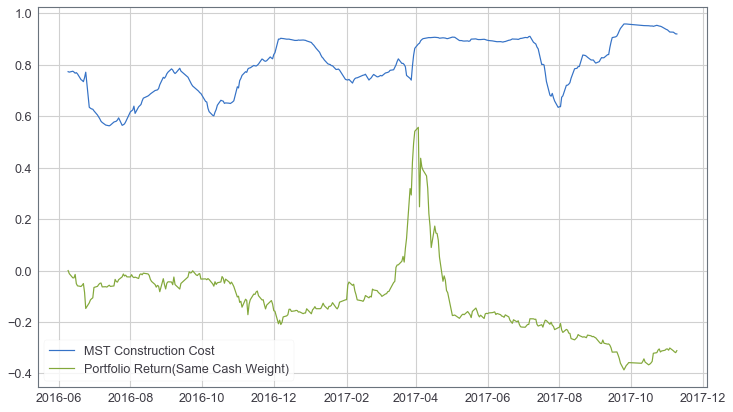

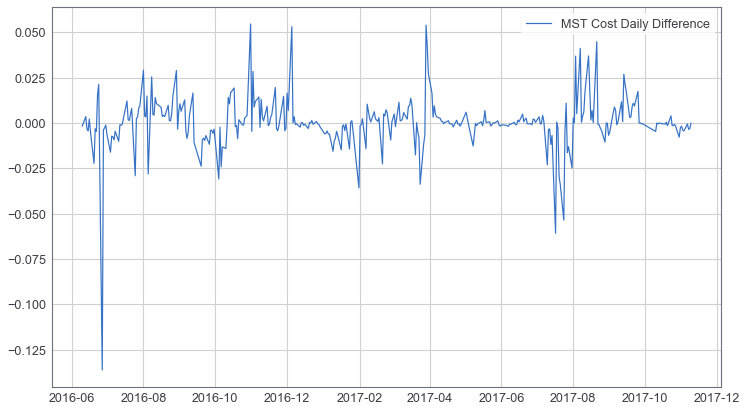

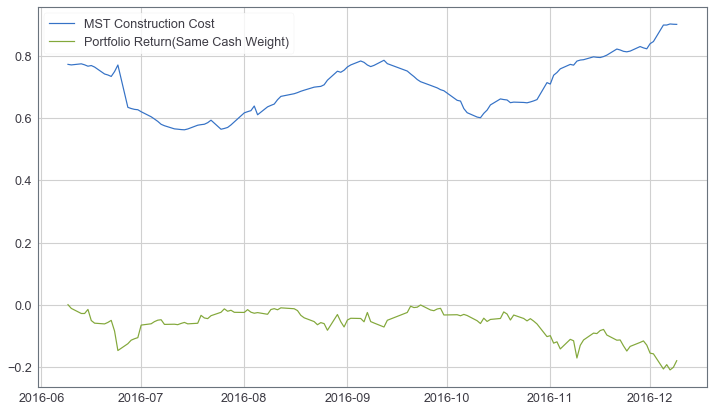

Mean :  0.703606005136319
Std :  0.08918212217129554
Port_folio_Std :  0.048035739901133634


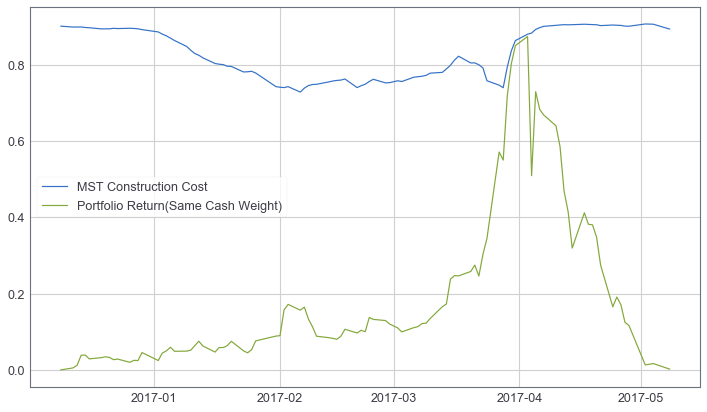

Mean :  0.8291693845787813
Std :  0.06419154923512982
Port_folio_Std :  0.21210832017418807


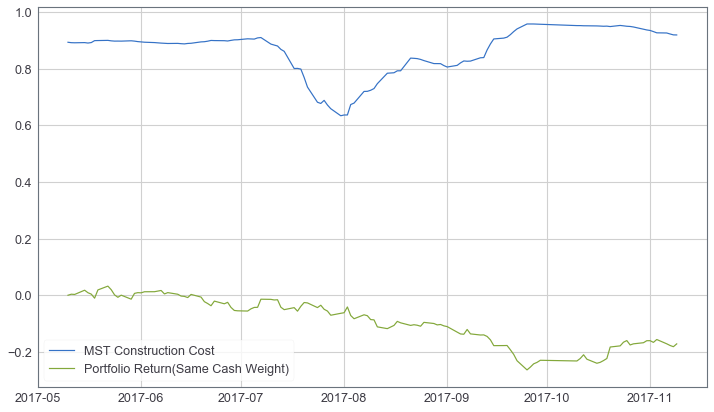

Mean :  0.8644512672977271
Std :  0.08264487310042103
Port_folio_Std :  0.08117538854649323


In [82]:
Ahn_1_network = construct_network(time_period,Ahn_1, AhnCheolSoo_stock)
# Ahn_1_network = construct_network((start_date, end_date),Ahn_1, df)

In [83]:
#문재인
Moon

['115500',
 '102120',
 '155660',
 '065650',
 '042110',
 '096630',
 '069730',
 '119850',
 '002140',
 '035890',
 '039560']

In [84]:
MoonJaeIn_stock = pd.read_csv('MoonJaeIn.csv',index_col=0)
MoonJaeIn_stock['date'] = pd.to_datetime(MoonJaeIn_stock['date'])
MoonJaeIn_stock['code'] = MoonJaeIn_stock['code'].apply(lambda x : x[1:])
MoonJaeIn_stock.head()

,date,code,close
0,2016-01-04,155660,4030.0
1,2016-01-04,035890,1030.0
2,2016-01-04,039560,6380.0
3,2016-01-04,069730,3785.0
4,2016-01-04,096630,1305.0


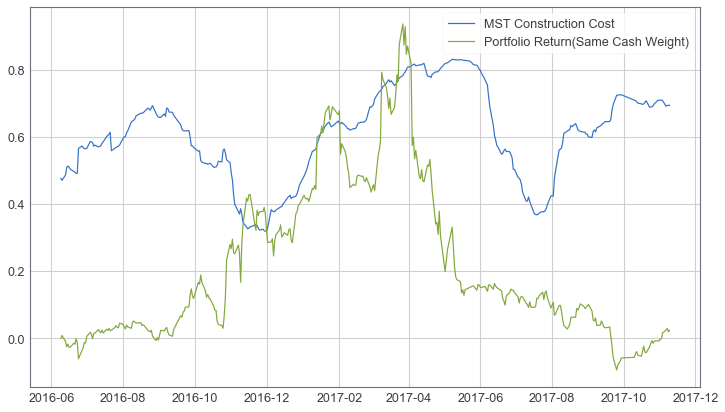

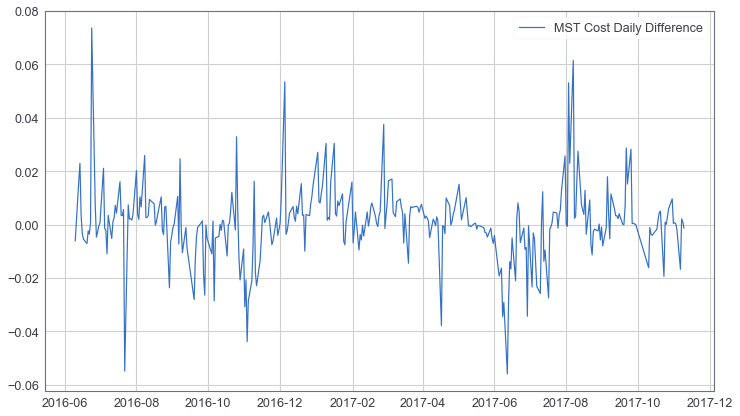

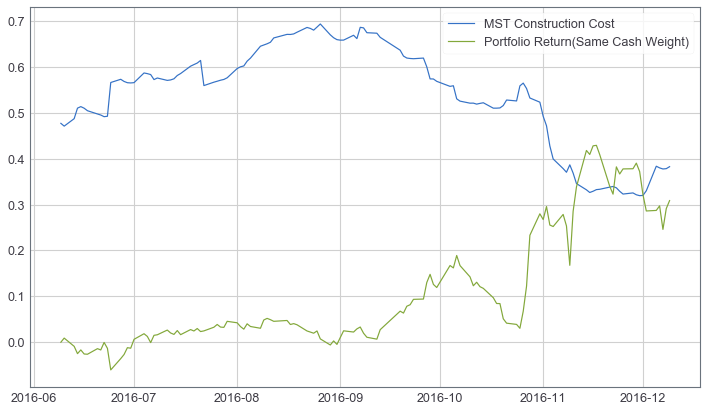

Mean :  0.5359619347611625
Std :  0.11138470467558019
Port_folio_Std :  0.1325509857390671


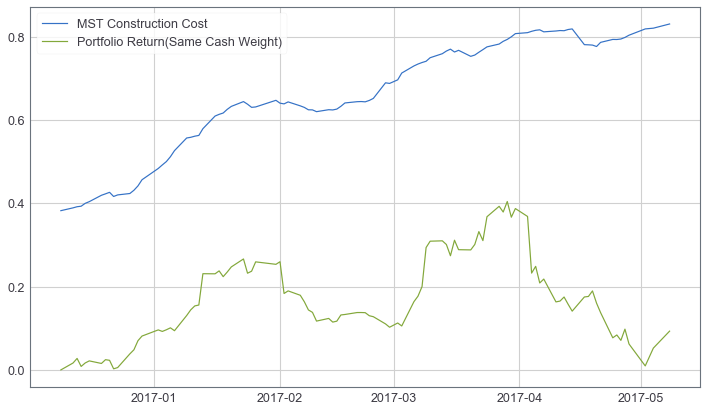

Mean :  0.6592263478271216
Std :  0.13592972924986058
Port_folio_Std :  0.10363426254497488


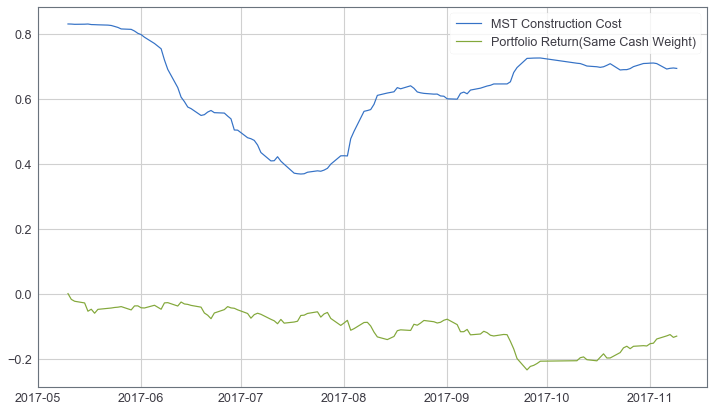

Mean :  0.6242257215327528
Std :  0.1326276387532093
Port_folio_Std :  0.0558683501183951


In [85]:
Moon_network = construct_network(time_period, Moon, MoonJaeIn_stock)

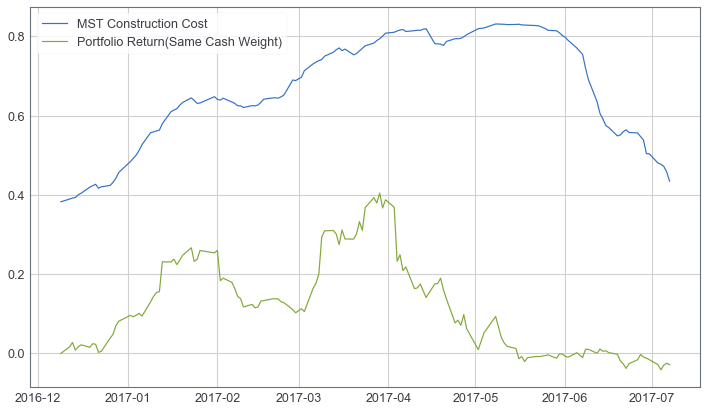

Mean :  0.664423526969483
Std :  0.13770242470977923
Port_folio_Std :  0.11872542449538191


In [86]:
Moon_network.plt_period(['2016-12-09','2017-07-09'])

In [87]:
#안희정
Ahn_2

['224060', '003310', '013720', '088290', '054410', '046310', '036120']

In [88]:
AhnHeeJung_stock = pd.read_csv('AhnHeeJung.csv',index_col=0)
AhnHeeJung_stock['date'] = pd.to_datetime(AhnHeeJung_stock['date'])
AhnHeeJung_stock['code'] = AhnHeeJung_stock['code'].apply(lambda x : x[1:])
AhnHeeJung_stock.head()

,date,code,close
0,2016-01-04,054410,10950.000
1,2016-01-04,013720,2825.000
2,2016-01-04,003310,1350.000
3,2016-01-04,224060,687.274
4,2016-01-04,046310,3229.330


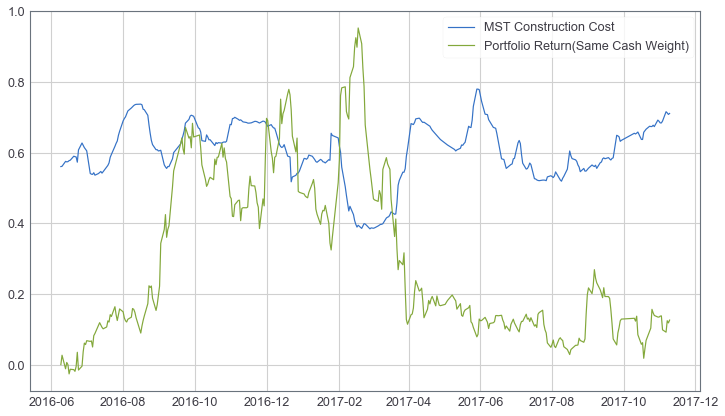

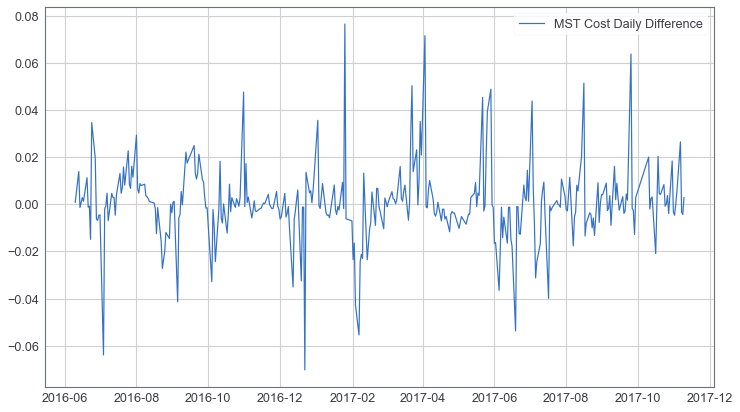

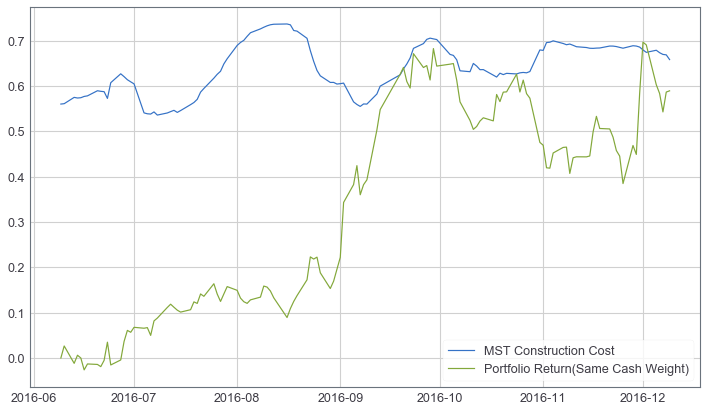

Mean :  0.6401450843444549
Std :  0.056390520455403895
Port_folio_Std :  0.23017924625436303


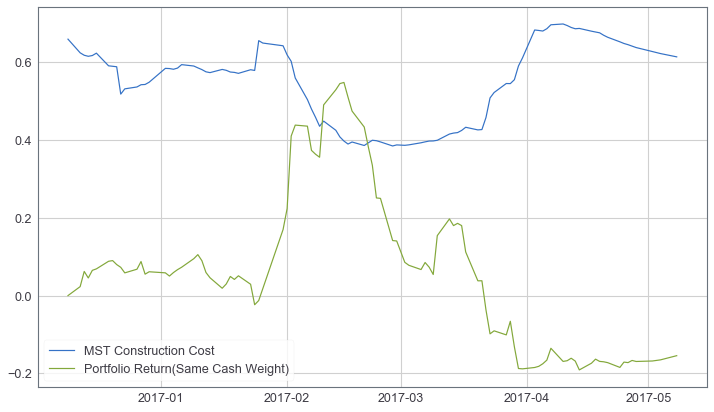

Mean :  0.5475404029795552
Std :  0.10273084456004807
Port_folio_Std :  0.19984483579866455


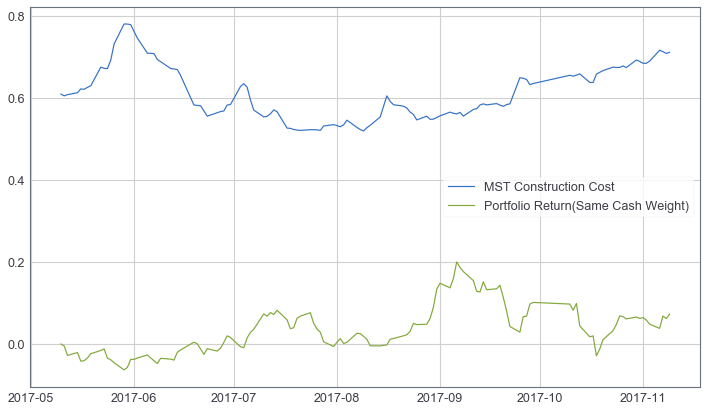

Mean :  0.6105955286506282
Std :  0.0664540962923429
Port_folio_Std :  0.058053836774741026


In [89]:
Ahn_2_network = construct_network(time_period, Ahn_2, AhnHeeJung_stock)

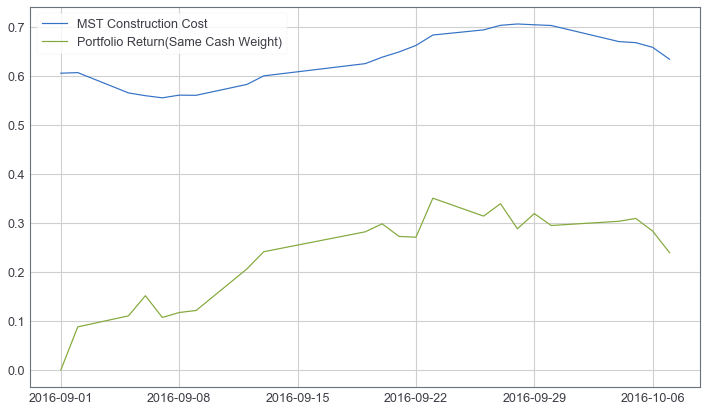

Mean :  0.6343981809518084
Std :  0.05325690614784373
Port_folio_Std :  0.0972721302182585


In [90]:
Ahn_2_network.plt_period(['2016-09-01','2016-10-08'])

<img src = "https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5b0aa9ef6a9ef969c36932a7/5db4effd34c19b4b0436f3cb34c4792b/image.png">

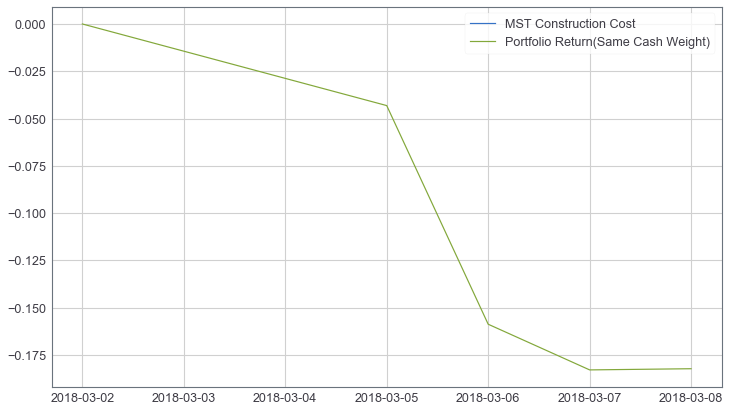

Mean :  nan


In [63]:
Ahn_2_network.plt_period(['2018-03-01','2018-03-08'])

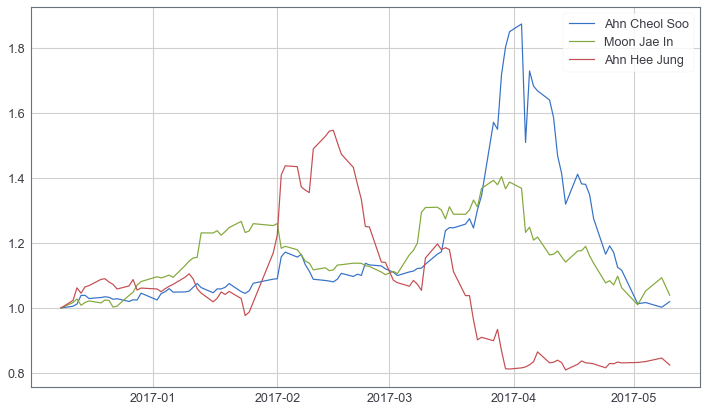

In [34]:
plt.figure(figsize=(12,7))

plt.plot(Ahn_1_network.get_portfolio(('2016-12-09','2017-05-10')), label='Ahn Cheol Soo')
plt.plot(Moon_network.get_portfolio(('2016-12-09','2017-05-10')), label='Moon Jae In')
plt.plot(Ahn_2_network.get_portfolio(('2016-12-09','2017-05-10')), label='Ahn Hee Jung')

plt.legend()
plt.show()

In [35]:
# Average 사용
class construct_network:
    
    def __init__(self,period,stock_list,stock_data):
        self.stock_data = stock_data
        self.stock_data = self.stock_data.set_index(['date','code']).unstack()
        self.stock_data = self.stock_data['close']
        self.period = self.stock_data[period[0]:period[1]].index
        self.stock_list = stock_list
        self.portfolio = self.get_portfolio(self.period)
        self.cost = pd.Series(self.period).apply(lambda x : self.get_cost(x)) 
        self.cost.index = self.period
        self.plot_things()        
    
    def get_portfolio(self,period):
        stock_data = self.stock_data[period[0]:period[-1]]
        return stock_data.apply(lambda x : x/x.iloc[0], axis=0).sum(axis=1)/len(self.stock_data.columns)
        
    # min_max scale 함수
    def get_minmax_scale(self, series):
        return (series-series.min())/(series.max()-series.min())
    
    def get_cost(self,date):
        period=100
        start_date = date + datetime.timedelta(days=-period)
        G = nx.Graph()
        G.add_nodes_from(self.stock_list)
        for i in list(G.nodes):
            G.nodes[i]['data'] = self.get_minmax_scale(self.stock_data[i][start_date:date]).fillna(0)

        iter_list = combinations(list(G.nodes),2)
        for i in iter_list:
            d1 = G.nodes[i[0]]['data']
            d2 = G.nodes[i[1]]['data']
            sim = 1 - spatial.distance.cosine(d1, d2)
            G.add_edge(i[0],i[1],weight=sim)


        # nx.draw(G_mst,with_labels=True)

        edges = list(G.edges)
        cost = 0

        for i in edges:
            cost += G.edges[i]['weight'] #Using Average Weight Here
        # print(start_date, date, cost)

        return 2 * cost / (len(self.stock_list) * (len(self.stock_list)-1))
    
    def plot_things(self):
        self.plt_result()
        before_period = self.stock_data[self.period[0]:'2016-12-09'].index
        during_period = self.stock_data['2016-12-09':'2017-05-09'].index
        after_period = self.stock_data['2017-05-09':self.period[-1]].index
        self.plt_period(before_period)
        self.plt_period(during_period)
        self.plt_period(after_period)
    
    def plt_result(self):
        plt.figure(figsize=(12,7))
        plt.plot(self.cost, label='MST Construction Cost')
        plt.plot(self.portfolio - 1, label='Portfolio Return(Same Cash Weight)')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(12,7))
        plt.plot(self.cost.rolling(window=2).apply(lambda x : x[1] - x[0]), label='MST Cost Daily Difference')
        plt.legend()
        plt.show()
        return 0
    
    def plt_period(self,period):
        plt.figure(figsize=(12,7))
        port = self.get_portfolio(period)
        plt.plot(self.cost[period[0]:period[-1]], label='MST Construction Cost')
        plt.plot(port - 1, label='Portfolio Return(Same Cash Weight)')
        plt.legend()
        plt.show()       

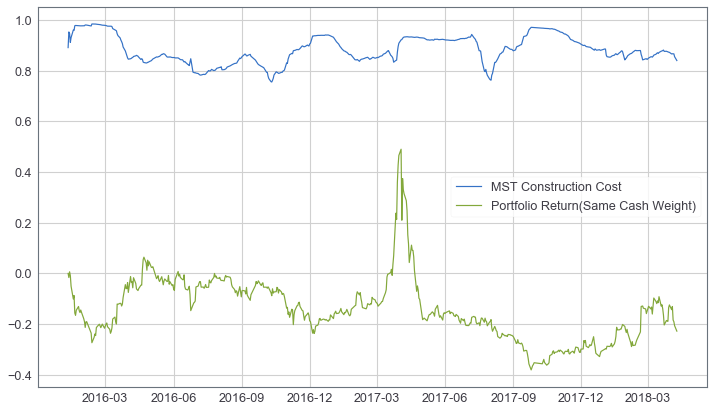

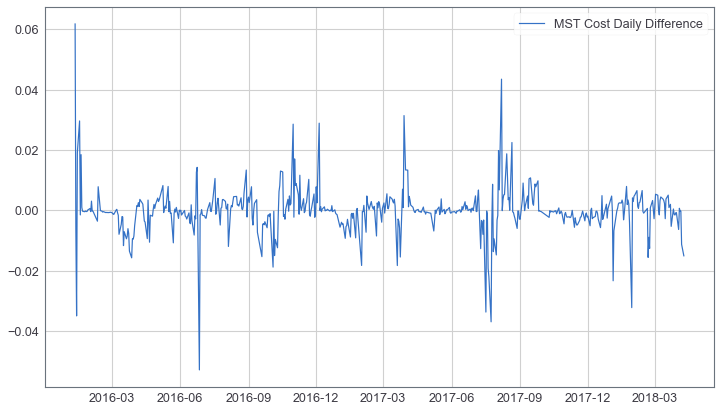

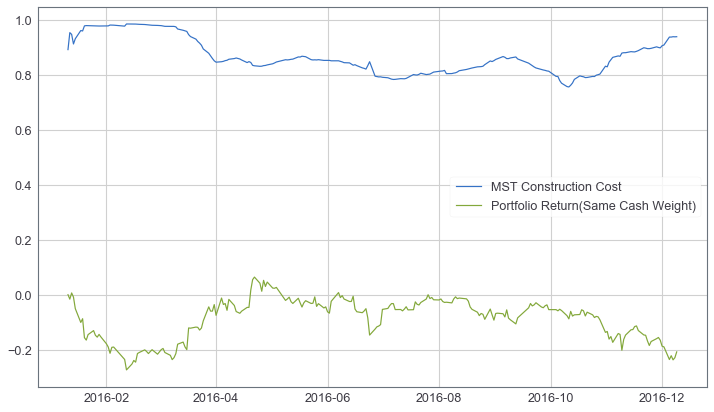

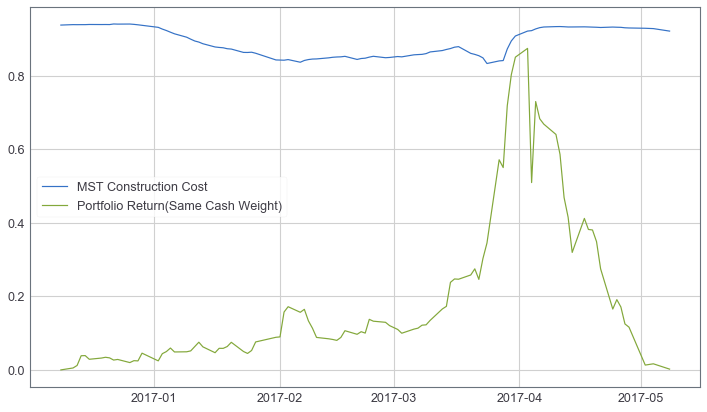

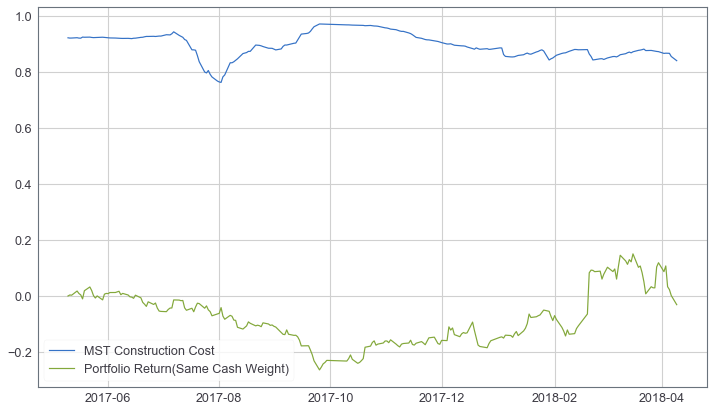

In [36]:
Ahn_1_network = construct_network(time_period,Ahn_1, AhnCheolSoo_stock)

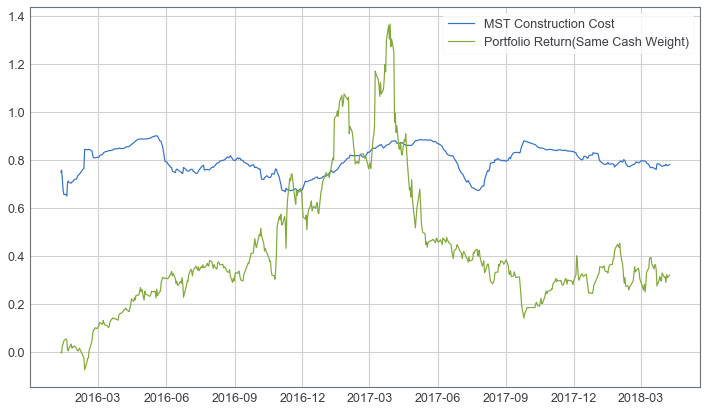

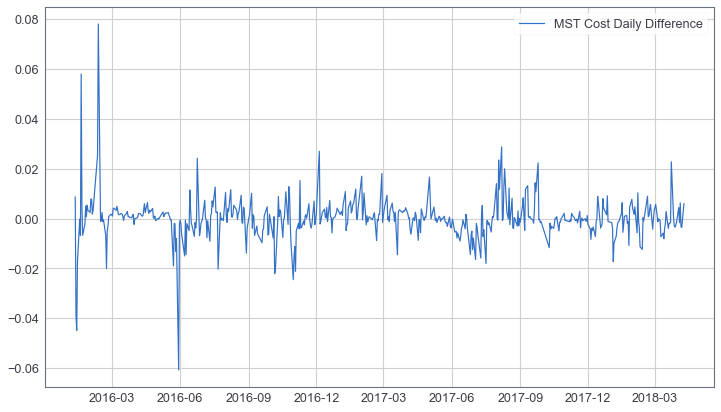

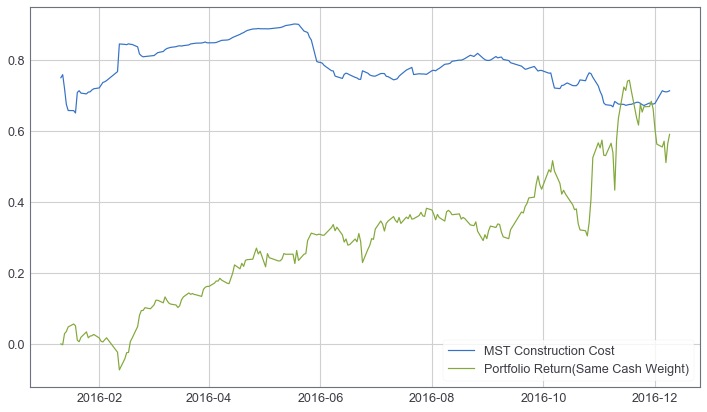

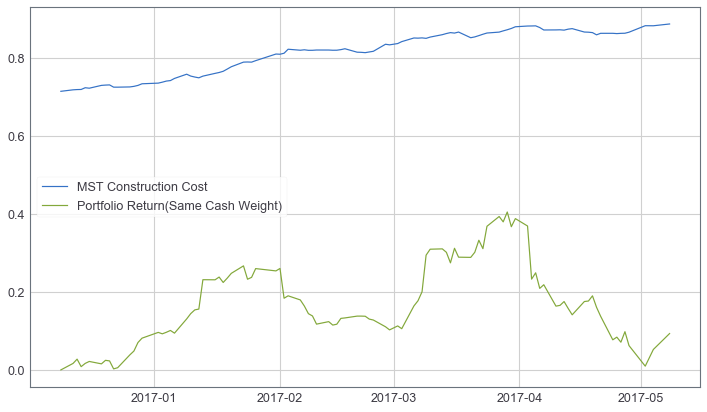

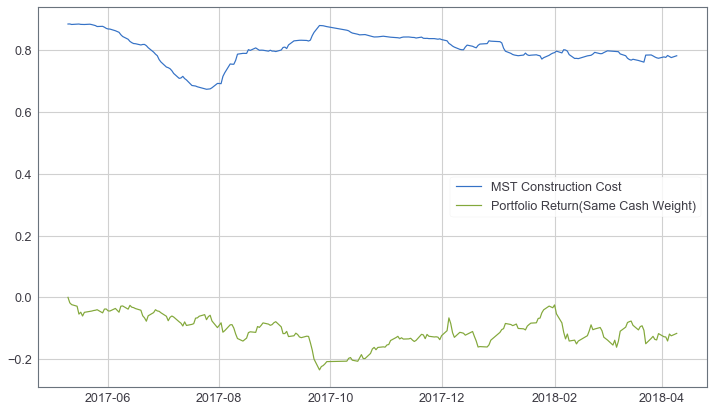

In [38]:
Moon_network = construct_network(time_period,Moon, MoonJaeIn_stock)

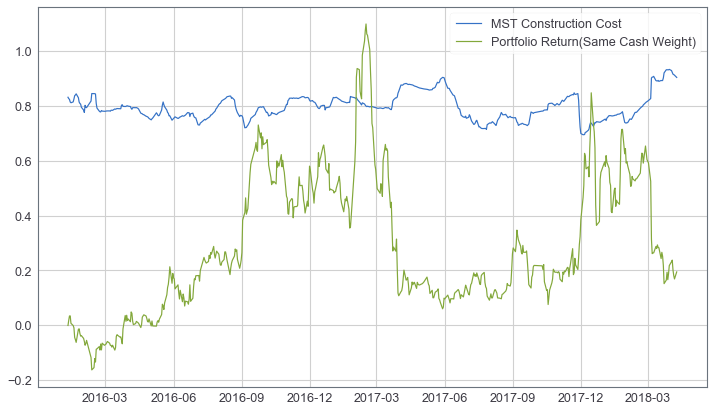

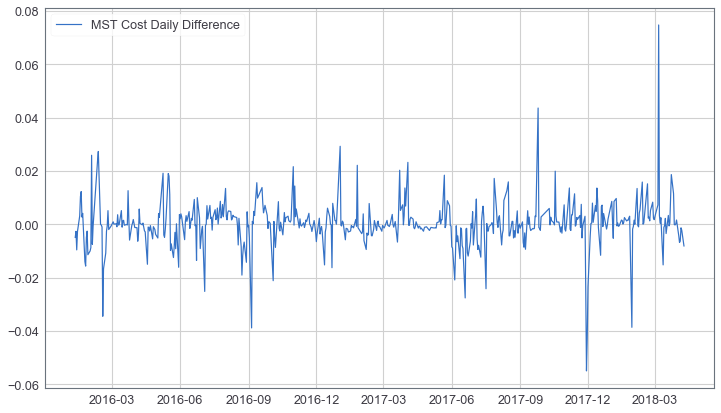

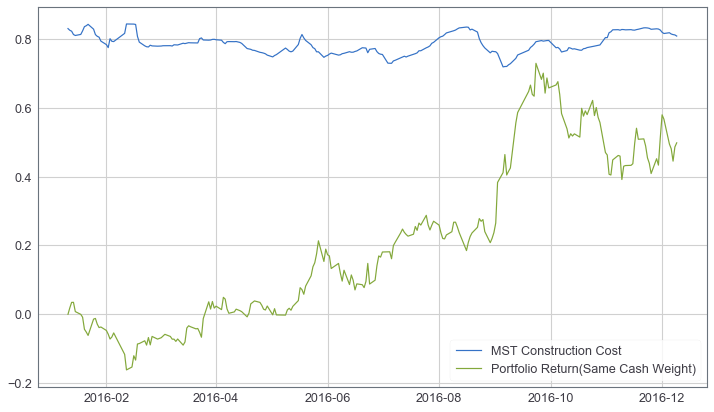

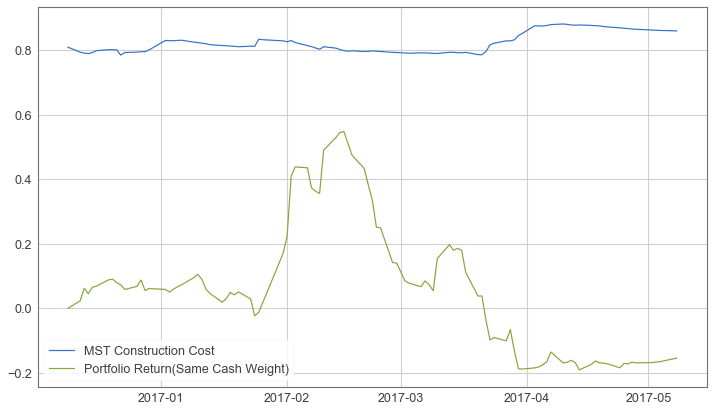

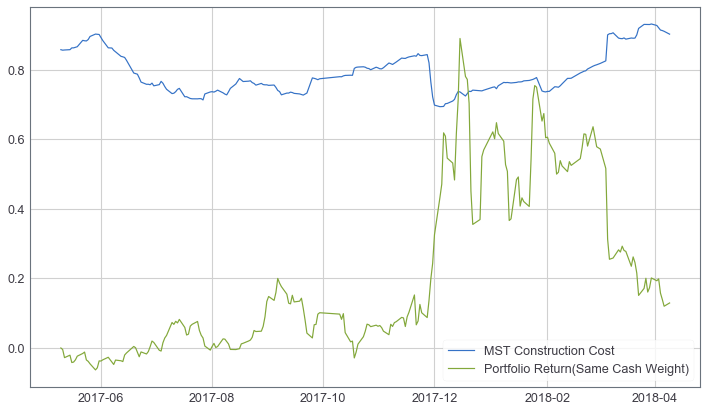

In [39]:
Ahn2_network = construct_network(time_period,Ahn_2, AhnHeeJung_stock)